In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
import numpy as np


2025-02-18 22:41:33.443756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739907693.542106   78594 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739907693.567848   78594 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 22:41:33.834600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Custom Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)

    def call(self, inputs):
        """
        inputs: Tensor of shape (batch_size, seq_len, d_model)
        returns: inputs + positional encodings
        """
        seq_len = tf.shape(inputs)[1]
        d_model = tf.shape(inputs)[2]
        # Compute the positional encodings
        positions = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)  # (seq_len, 1)
        dims = tf.cast(tf.range(d_model)[tf.newaxis, :], tf.float32)       # (1, d_model)
        angle_rates = 1 / tf.pow(10000.0, (2 * (dims // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = positions * angle_rates  # (seq_len, d_model)

        # Apply sin to even indices and cos to odd indices
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = tf.expand_dims(pos_encoding, 0)  # (1, seq_len, d_model)
        
        return inputs + pos_encoding

# Define a Transformer Encoder block
def transformer_encoder_block(inputs, num_heads, ff_dim, dropout_rate):
    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    
    # Feed-forward network
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return out2

# Build the Transformer-based model
def create_transformer_model(input_shape, num_heads=4, ff_dim=128, dropout_rate=0.1, num_transformer_blocks=1):
    """
    Parameters:
      input_shape: tuple, e.g. (window_size, num_features)
      num_heads: Number of attention heads.
      ff_dim: Dimension of the feed-forward network.
      dropout_rate: Dropout rate.
      num_transformer_blocks: Number of stacked Transformer blocks.
    """
    inputs = Input(shape=input_shape)  # (batch_size, seq_len, num_features)
    
    # Add positional encoding to maintain sequential information.
    x = PositionalEncoding()(inputs)
    
    # Apply one or more Transformer encoder blocks.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_block(x, num_heads, ff_dim, dropout_rate)
    
    # Global average pooling over the sequence dimension.
    x = GlobalAveragePooling1D()(x)
    
    # Output layer for binary classification.
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [3]:
def train_test_split_by_date(x, y, test_size=0.2):
    """
    Split the input data into training and test sets by date.
    The test set should contain the newest test_size proportion of the data.
    """
    df = pd.concat([x, y], axis=1)
    df = df.sort_values(by='author_date_unix_timestamp')
    split_index = int((1 - test_size) * len(df))
    x_train = df.iloc[:split_index, :-1]
    y_train = df.iloc[:split_index, -1]
    x_test = df.iloc[split_index:, :-1]
    y_test = df.iloc[split_index:, -1]
    return x_train, x_test, y_train, y_test

from sklearn.feature_selection import SelectFromModel
from mrmr import mrmr_classif

def select_features(x, y, method="model", estimator=None, threshold="median", 
                    correlation_threshold=0.9, num_features=50):
    """
    Select features using different methods.

    Parameters:
      - x: Training features (pandas DataFrame)
      - y: Training labels (pandas Series)
      - method: Which feature selection method to use.
                Options are:
                  "model" : Model-based feature selection using SelectFromModel.
                  "cbfs"  : Correlation-based feature selection (CBFS).
                  "mrmr"  : Minimum Redundancy Maximum Relevance (MRMR) using mrmr_selection.
      - estimator: (For "model" method) An estimator to compute feature importances.
                   If None, an XGBClassifier is used.
      - threshold: (For "model" method) The threshold for feature importance in SelectFromModel.
                   Default is "median".
      - correlation_threshold: (For "cbfs" method) Threshold to drop highly correlated features.
      - num_features: (For "mrmr" method) Number of features to select.
      
    Returns:
      - A list of selected feature names.
    """
    method = method.lower()
    if method == "model":
        if estimator is None:
            estimator = XGBClassifier(tree_method="hist", device="cuda", random_state=42)
        estimator.fit(x, y)
        selector = SelectFromModel(estimator, threshold=threshold, prefit=True)
        selected_features = list(x.columns[selector.get_support()])
        return selected_features

    elif method == "cbfs":
        # Compute the absolute correlation matrix and remove one of any pair of highly correlated features.
        corr_matrix = x.corr().abs()
        # Use only the upper triangle of the correlation matrix.
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
        selected_features = [col for col in x.columns if col not in to_drop]
        return selected_features

    elif method == "mrmr":
        # Call mrmr_classif directly with the DataFrame (not x.values) so that it can access the column names.
        selected_features = mrmr_classif(x, y, K=num_features)
        return selected_features

    else:
        raise ValueError("Method must be one of 'model', 'cbfs', or 'mrmr'")
    
    # all columns in the dataset
INFO_COLUMNS = [
                "type", #"linked", "fileschanged",
                "ndev", "age", "exp", "rexp", "sexp",
                "glm_probability", "classification",
                "time_of_day", "day_of_week", "is_weekend",
                "author_experience", "author_ownership",
                "hash","file", "author_date_unix_timestamp"]

Y_COLUMN = ['contains_bug']

X_COLUMNS = ["d_cbo","d_cboModified","d_fanin",
             "d_fanout","d_wmc","d_dit","d_noc",
             "d_rfc","d_lcom","d_lcom*","d_tcc",
             "d_lcc","d_totalMethodsQty","d_staticMethodsQty",
             "d_publicMethodsQty","d_privateMethodsQty","d_protectedMethodsQty",
             "d_defaultMethodsQty","d_visibleMethodsQty","d_abstractMethodsQty",
             "d_finalMethodsQty","d_synchronizedMethodsQty","d_totalFieldsQty",
             "d_staticFieldsQty","d_publicFieldsQty","d_privateFieldsQty",
             "d_protectedFieldsQty","d_defaultFieldsQty","d_finalFieldsQty",
             "d_synchronizedFieldsQty","d_nosi","d_loc","d_returnQty","d_loopQty",
             "d_comparisonsQty","d_tryCatchQty","d_parenthesizedExpsQty","d_stringLiteralsQty",
             "d_numbersQty","d_assignmentsQty","d_mathOperationsQty","d_variablesQty",
             "d_maxNestedBlocksQty","d_anonymousClassesQty","d_innerClassesQty",
             "d_lambdasQty",
             #"d_uniqueWordsQty",
             "d_modifiers",
             #"d_logStatementsQty",
             "cbo","cboModified","fanin","fanout","wmc","dit","noc","rfc","lcom","lcom*",
             "tcc","lcc","totalMethodsQty","staticMethodsQty","publicMethodsQty",
             "privateMethodsQty","protectedMethodsQty","defaultMethodsQty",
             "visibleMethodsQty","abstractMethodsQty","finalMethodsQty",
             "synchronizedMethodsQty","totalFieldsQty","staticFieldsQty",
             "publicFieldsQty","privateFieldsQty","protectedFieldsQty",
             "defaultFieldsQty","finalFieldsQty","synchronizedFieldsQty",
             "nosi","loc","returnQty","loopQty","comparisonsQty",
             "tryCatchQty","parenthesizedExpsQty","stringLiteralsQty",
             "numbersQty","assignmentsQty","mathOperationsQty",
             "variablesQty","maxNestedBlocksQty","anonymousClassesQty",
             "innerClassesQty","lambdasQty",
             #"uniqueWordsQty", # Number of unique words in the source code
             "modifiers",
             #"logStatementsQty", # Number of log statements in the source code
             #"fix",
             "entrophy",
             "la","ld",
             #"net_lines_changed","absolute_lines_changed",
             "lines_per_file",
             "changed_file_count",
             #"entropy_bucket",
             ]

DATASETS = ["merged_datasets/new/broadleaf_merged_df.csv",
            "merged_datasets/new/camel_merged_df.csv",
            "merged_datasets/new/dubbo_merged_df.csv",
            "merged_datasets/new/elasticsearch_merged_df.csv",
            "merged_datasets/new/guava_merged_df.csv",
            "merged_datasets/new/jdk_merged_df.csv",
            "merged_datasets/new/jgroups_merged_df.csv",
            "merged_datasets/new/kafka_merged_df.csv",
            "merged_datasets/new/spark_merged_df.csv",
            "merged_datasets/new/spring-boot_merged_df.csv",
            "merged_datasets/new/spring-framework_merged_df.csv",
            "merged_datasets/new/tomcat_merged_df.csv",
            ]

In [4]:
def create_sliding_window(X, y, window_size):
    """
    Transform the data into sequences using a sliding window approach.
    
    Parameters:
      X (np.array): Array of features (already scaled).
      y (np.array): Array of target values.
      window_size (int): Number of consecutive rows in each window.
    
    Returns:
      X_seq (np.array): Array of sequences with shape (samples, window_size, features).
      y_seq (np.array): Array of labels corresponding to each sequence.
                         Here, the label for a window is the label of the last row.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size + 1):
        X_seq.append(X[i: i+window_size])
        y_seq.append(y[i+window_size-1])
    return np.array(X_seq), np.array(y_seq)

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

dataset_file = DATASETS[0]
df = pd.read_csv(dataset_file)

df = df.fillna(-1)

# Extract features and target. Make sure these columns exist in the CSV.
X = df[X_COLUMNS + INFO_COLUMNS]
y = df[Y_COLUMN]

# Split the dataset by date using the provided function
x_train, x_test, y_train, y_test = train_test_split_by_date(X, y, test_size=0.2)

# Perform feature selection on the training set using only X_COLUMNS
selected_features = select_features(x_train[X_COLUMNS], y_train,
                                            method="cbfs", correlation_threshold=1)
print(f"Selected features: {selected_features}")
print(len(selected_features))

# Scale the features (LSTM models often perform better with scaled inputs)
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train[selected_features])
x_test_scaled = scaler.transform(x_test[selected_features])

# Define the sliding window size (N)
window_size = 25  

# Create sliding windows for both the training and test sets.
# The label for each window is taken as the label of the last row in that window.
x_train_seq, y_train_seq = create_sliding_window(x_train_scaled, y_train.to_numpy(), window_size)
x_test_seq, y_test_seq = create_sliding_window(x_test_scaled, y_test.to_numpy(), window_size)

Selected features: ['d_cbo', 'd_cboModified', 'd_fanin', 'd_fanout', 'd_wmc', 'd_dit', 'd_noc', 'd_rfc', 'd_lcom', 'd_lcom*', 'd_tcc', 'd_lcc', 'd_totalMethodsQty', 'd_staticMethodsQty', 'd_publicMethodsQty', 'd_privateMethodsQty', 'd_protectedMethodsQty', 'd_defaultMethodsQty', 'd_visibleMethodsQty', 'd_abstractMethodsQty', 'd_finalMethodsQty', 'd_synchronizedMethodsQty', 'd_totalFieldsQty', 'd_staticFieldsQty', 'd_publicFieldsQty', 'd_privateFieldsQty', 'd_protectedFieldsQty', 'd_defaultFieldsQty', 'd_finalFieldsQty', 'd_synchronizedFieldsQty', 'd_nosi', 'd_loc', 'd_returnQty', 'd_loopQty', 'd_comparisonsQty', 'd_tryCatchQty', 'd_parenthesizedExpsQty', 'd_stringLiteralsQty', 'd_numbersQty', 'd_assignmentsQty', 'd_mathOperationsQty', 'd_variablesQty', 'd_maxNestedBlocksQty', 'd_anonymousClassesQty', 'd_innerClassesQty', 'd_lambdasQty', 'd_modifiers', 'cbo', 'cboModified', 'fanin', 'fanout', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom*', 'tcc', 'lcc', 'totalMethodsQty', 'staticMethodsQty

In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Get unique classes and compute weights
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(y_train_seq), 
                                     y=y_train_seq)

# Convert to a dictionary format required by Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)

# Convert to a dictionary format required by Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

Class Weights: {0: np.float64(0.7973117901473329), 1: np.float64(1.3408680997013689)}


In [7]:
# Example usage:
# Assuming x_train_seq and x_test_seq are your sliding window sequences with shape (samples, window_size, num_features)
input_shape = (x_train_seq.shape[1], x_train_seq.shape[2])
transformer_model = create_transformer_model(input_shape, num_heads=4, ff_dim=128, dropout_rate=0.1, num_transformer_blocks=2)

# Print the model summary
transformer_model.summary()

# Train the model (using the same training and validation sets as before)
history = transformer_model.fit(x_train_seq, y_train_seq,
                                epochs=10,
                                batch_size=32,
                                validation_data=(x_test_seq, y_test_seq),
                                class_weight=class_weight_dict)



I0000 00:00:1739907704.340472   78594 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 99)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 25, 99)    │          0 │ input_layer[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 25, 99)    │    158,103 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 25, 99)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 99)    │          0 │ positional_encod… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 25, 99)    │        198 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25, 128)   │     12,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 25, 99)    │     12,771 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 25, 99)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 25, 99)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 99)    │        198 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 25, 99)    │    158,103 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 25, 99)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 25, 99)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 25, 99)    │        198 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 25, 128)   │     12,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25, 99)    │     12,771 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 25, 99)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 25, 99)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 368,240 (1.40 MB)

 Trainable params: 368,240 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

2025-02-18 22:41:47.774097: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 897920100 exceeds 10% of free system memory.
2025-02-18 22:41:49.111412: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 897920100 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1739907713.740275   78820 service.cc:148] XLA service 0x7f8da4008040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739907713.740910   78820 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-02-18 22:41:53.892739: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739907714.547561   78820 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/2835 ━━━━━━━━━━━━━━━━━━━━ 2:11 46ms/step - accuracy: 0.5052 - loss: 1.2348  

2025-02-18 22:41:59.966152: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_multiply_reduce_fusion', 52 bytes spill stores, 48 bytes spill loads

I0000 00:00:1739907720.006190   78820 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2835/2835 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7131 - loss: 0.5928

2025-02-18 22:42:27.307023: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224304300 exceeds 10% of free system memory.
2025-02-18 22:42:27.470533: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224304300 exceeds 10% of free system memory.


2835/2835 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - accuracy: 0.7132 - loss: 0.5928 - val_accuracy: 0.7761 - val_loss: 0.6464
Epoch 2/10
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.7692 - loss: 0.5201 - val_accuracy: 0.7606 - val_loss: 0.6786
Epoch 3/10
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.7705 - loss: 0.5052 - val_accuracy: 0.7136 - val_loss: 0.6158
Epoch 4/10
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.7638 - loss: 0.5362 - val_accuracy: 0.7653 - val_loss: 0.5950
Epoch 5/10
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.7772 - loss: 0.4941 - val_accuracy: 0.7596 - val_loss: 0.5622
Epoch 6/10
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7775 - loss: 0.4903 - val_accuracy: 0.7645 - val_loss: 0.6242
Epoch 7/10
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.7759 - loss: 0.4936 - val_accuracy: 0.7752 - val_loss: 0.6228
Epoch 8/10
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.7702 - loss: 0.5190 - v

In [8]:
# Evaluate the model
test_metrics = transformer_model.evaluate(x_test_seq, y_test_seq)
print(f'Test loss: {test_metrics[0]:.4f}, Test accuracy: {test_metrics[1]:.4f}')

# Make predictions and generate a classification report (as before)
y_pred_probs = transformer_model.predict(x_test_seq)
y_pred = (y_pred_probs > 0.5).astype(int)



 11/709 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 1.0000 - loss: 0.1292  

2025-02-18 22:46:27.322805: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224304300 exceeds 10% of free system memory.


709/709 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8532 - loss: 0.3408
Test loss: 0.4777, Test accuracy: 0.7774
709/709 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_seq, y_pred))




              precision    recall  f1-score   support

       False       0.75      0.23      0.35      5949
        True       0.78      0.97      0.87     16708

    accuracy                           0.78     22657
   macro avg       0.76      0.60      0.61     22657
weighted avg       0.77      0.78      0.73     22657



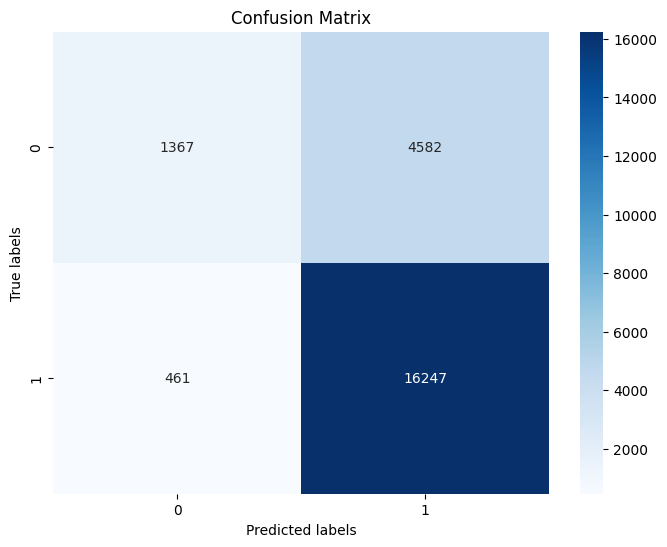

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()